In [7]:
import zipfile
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow_hub as hub
from tensorflow.keras import layers

!wget https://github.com/kekonline/My-First-TF-CNN/raw/master/Data.zip

zip_ref = zipfile.ZipFile("Data.zip", "r")
zip_ref.extractall()
zip_ref.close()

data_dir = pathlib.Path("Data/Train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)


--2024-01-08 19:35:26--  https://github.com/kekonline/My-First-TF-CNN/raw/master/Data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kekonline/My-First-TF-CNN/master/Data.zip [following]
--2024-01-08 19:35:26--  https://raw.githubusercontent.com/kekonline/My-First-TF-CNN/master/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5350733 (5.1M) [application/zip]
Saving to: ‘Data.zip.1’

Data.zip.1          100%[===================>]   5.10M  --.-KB/s    in 0.07s   

2024-01-08 19:35:26 (69.3 MB/s) - ‘Data.zip.1’ saved [5350733/5350733]

['Book' 'Game']


In [8]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [9]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [10]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

Image shape: (2016, 1512, 3)
Image shape: (2016, 1512, 3)


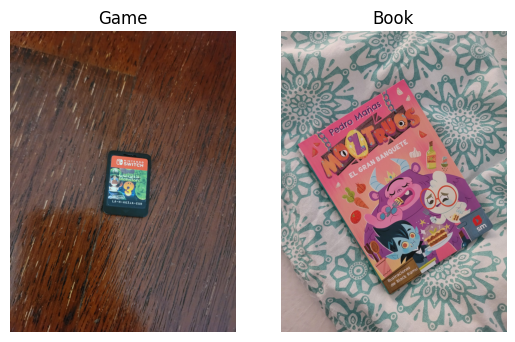

In [11]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("Data/Train/", "Game")
plt.subplot(1, 2, 2)
book_img = view_random_image("Data/Train/", "Book")

In [15]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Setup the train and test directories
train_dir = "Data/Train/"
test_dir = "Data/Test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

# Create our own model
model_1 = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer
    ])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/5
1/1 [==============================] - 11s 11s/step - loss: 1.0357 - accuracy: 0.3750 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 1s 657ms/step - loss: 0.8554 - accuracy: 0.3750 - val_loss: 0.6338 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 1s 621ms/step - loss: 0.7030 - accuracy: 0.5625 - val_loss: 0.5846 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 1s 667ms/step - loss: 0.5781 - accuracy: 0.7500 - val_loss: 0.5425 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 1s 688ms/step - loss: 0.4762 - accuracy: 0.7500 - val_loss: 0.5027 - val_accuracy: 0.5000


In [ ]:
model_1.summary()

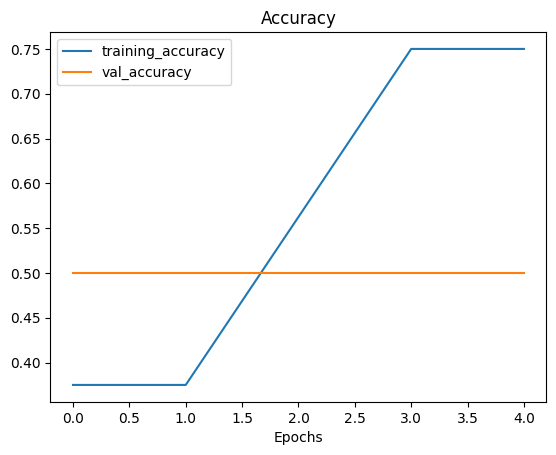

In [17]:
plot_loss_curves(history_1)

In [18]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [22]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

--2024-01-08 19:41:15--  https://www.ballpublishing.com/images/HardcoverRedBook.jpg
Resolving www.ballpublishing.com (www.ballpublishing.com)... 20.236.108.89
Connecting to www.ballpublishing.com (www.ballpublishing.com)|20.236.108.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433307 (423K) [image/jpeg]
Saving to: ‘HardcoverRedBook.jpg.2’

HardcoverRedBook.jp 100%[===================>] 423.15K  --.-KB/s    in 0.04s   

2024-01-08 19:41:15 (11.7 MB/s) - ‘HardcoverRedBook.jpg.2’ saved [433307/433307]

1/1 [==============================] - 0s 22ms/step


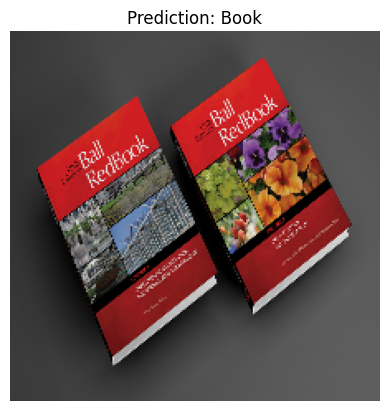

In [23]:
!wget https://www.ballpublishing.com/images/HardcoverRedBook.jpg
pred_and_plot(model_1, "HardcoverRedBook.jpg", class_names)

--2024-01-08 19:42:23--  https://www.8bitbeyond.com/cdn/shop/files/1032E048-7B13-4D5B-AAE8-3814F1C6E619_2048x2048.jpg
Resolving www.8bitbeyond.com (www.8bitbeyond.com)... 23.227.38.74
Connecting to www.8bitbeyond.com (www.8bitbeyond.com)|23.227.38.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469611 (459K) [image/jpeg]
Saving to: ‘1032E048-7B13-4D5B-AAE8-3814F1C6E619_2048x2048.jpg’

1032E048-7B13-4D5B- 100%[===================>] 458.60K  --.-KB/s    in 0.03s   

2024-01-08 19:42:24 (13.3 MB/s) - ‘1032E048-7B13-4D5B-AAE8-3814F1C6E619_2048x2048.jpg’ saved [469611/469611]

1/1 [==============================] - 0s 35ms/step


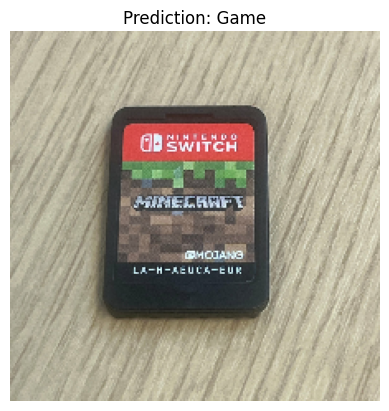

In [24]:
!wget https://www.8bitbeyond.com/cdn/shop/files/1032E048-7B13-4D5B-AAE8-3814F1C6E619_2048x2048.jpg
pred_and_plot(model_1, "1032E048-7B13-4D5B-AAE8-3814F1C6E619_2048x2048.jpg", class_names)

--2024-01-08 19:43:45--  https://media.karousell.com/media/photos/products/2023/10/25/africans_style_photo_boook_1698194578_0bad9e5f_progressive.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.246.83, 190.93.245.83, 190.93.244.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.246.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181437 (177K) [image/jpeg]
Saving to: ‘africans_style_photo_boook_1698194578_0bad9e5f_progressive.jpg.1’

africans_style_phot 100%[===================>] 177.18K  --.-KB/s    in 0.02s   

2024-01-08 19:43:45 (7.26 MB/s) - ‘africans_style_photo_boook_1698194578_0bad9e5f_progressive.jpg.1’ saved [181437/181437]

1/1 [==============================] - 0s 21ms/step


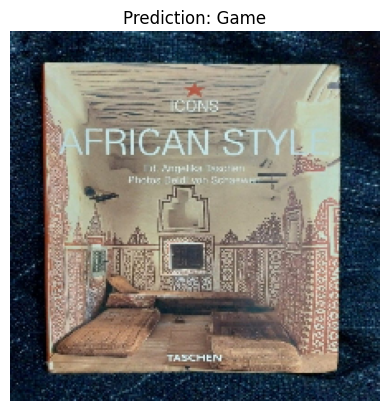

In [26]:
!wget https://media.karousell.com/media/photos/products/2023/10/25/africans_style_photo_boook_1698194578_0bad9e5f_progressive.jpg
pred_and_plot(model_1, "africans_style_photo_boook_1698194578_0bad9e5f_progressive.jpg", class_names)